# Set Up/Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# conda activate "/pscratch/sd/m/mansisak/memorization/env/"

In [3]:
# !pip list

In [4]:
#pip install accelerate

In [5]:
import torch
import os
from transformers import AutoModelForCausalLM
from torch.utils.data import DataLoader
from tqdm import tqdm

### TODO: figure out automatically
# device = "cpu"
device = "cuda"

/global/cfs/cdirs/m636/geniesse/envs/memorization/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# Load in Models

In [6]:
def print_edited_model_paths(parent_path):
    
    total_exp = 0
    for model_name in ['pythia-6.9b-deduped', 'pythia-2.8b-deduped']:
        y_idx = 0
        for step in [36000, 72000, 108000, 143000]:
            for loc_method in [
                  "act",
                  "hc",
                  "slim",
                  "durable",
                  "durable_agg",
                  "random",
                  "random_greedy",
                  "greedy",
              ]:
                
                for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3]:
                    result_path = f"{parent_path}{step}/EleutherAI_edit/{loc_method}/mem/{ratio}"
                    if loc_method not in ["random", "random_greedy"]:
                        if ratio >= 0.1:
                            continue

                    # this ratio is too small for neuron-level methods
                    if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                        if ratio <= 0.0001:
                            continue

                    if loc_method in ["greedy"]:
                        if ratio > 0.00001:
                            continue
                            
                    ######
                    if loc_method in ["greedy", "durable", "durable_agg","act"]:
                        model_path = f'{result_path}/{model_name}'
                        total_exp += 1

                    if loc_method in ["slim", "hc"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = f'{result_path}/{epochs}/1000/0.1/0.1/{model_name}'                      

                    if loc_method in ["random", "random_greedy"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = f'{result_path}/{epochs}/0.1/0.9/0.0005/{model_name}'
                    if os.path.isfile(model_path):
                        print("edited model exists:", model_path)
                    else:
                        print("edited model doesn't exist yet: ", model_path)

    print("total_expeirments: ", total_exp)



In [7]:
# parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"
parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"

print_edited_model_paths(parent_path)

edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/act/mem/0.001/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/act/mem/0.01/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/act/mem/0.05/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/hc/mem/0.001/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/hc/mem/0.01/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/hc/mem/0.05/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/slim/mem/0.001/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/mo

In [8]:
# Example of how to load in a model:

model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-2.8b-deduped",
    torch_dtype=torch.float16,
    # torch_dtype=torch.float32,
    device_map=device
)

# sd_path = '/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/random_greedy/mem/0.001/20/0.1/0.9/0.0005/pythia-2.8b-deduped'
sd_paths = dict(
    unedited = None,
    good_edit = "/pscratch/sd/m/mansisak/memorization/model_ckpts/143000/EleutherAI_edit/random_greedy/mem/0.001/20/0.1/0.9/0.0005/pythia-2.8b-deduped",
    bad_edit = "/pscratch/sd/m/mansisak/memorization/model_ckpts/143000/EleutherAI_edit/random/mem/0.1/20/0.1/0.9/0.0005/pythia-2.8b-deduped",
)

# choose which model to load
use_model = "unedited"
sd_path = sd_paths.get(use_model)

if sd_path is not None:
    sd = torch.load(sd_path, map_location=device)["model_state_dict"]
    if "random" in sd_path:
        for k in sd:
            if "4h" in k:
                #rint(sd[k].shape)
                #rint(k)
                sd[k] = sd[k].T
    model.load_state_dict(sd, assign=True)
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2560)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2560, out_features=10240, bias=True)
          (dense_4h_to_h): Linear(in_features=10240, out_features=2560, bias=True)


In [9]:
!ls -ls /pscratch/sd/m/mansisak/memorization/model_ckpts/143000

total 4
4 drwxr-xr-x 11 mansisak mansisak 4096 Sep  3 06:26 EleutherAI_edit


In [10]:
model.device

device(type='cuda', index=0)

# Load in Data

In [11]:
random_data = torch.load("/pscratch/sd/m/mansisak/memorization/src/data/pythia_mem_data/pile_random_batch.pt")
random_data_pile = torch.reshape(random_data[0:2040], (3264, 80))#.to(device)

# random_data = random_data_pile[0:1632]
random_subset_data = random_data_pile[0:10] # for testing purposes
# extra_data = random_data_pile[1632:]
# random_dataloader = DataLoader(random_data, batch_size=1, shuffle=False)
# random_subset_dataloader = DataLoader(random_subset_data, batch_size=1, shuffle=False)
# random_dataloader


random_subset_data = random_subset_data.to(device)

# Model Inference

In [12]:
def perplexity(model, dataloader):
    avg_metric = 0
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            model_output = model(batch, labels=batch)
        loss = model_output.loss
        loss_exp = torch.exp(loss)
        if torch.isinf(loss_exp):
            print(f"Skipping invalid loss...")
            print(f"    {i=}, loss={loss.item()}, exp(loss)={torch.exp(loss).item()}")
        avg_metric += loss_exp
        # print(loss.item())
    return avg_metric / len(dataloader)


def perplexity_criterion(model_output, targets=None):
    loss = model_output.loss
    return torch.exp(loss)


def average_loss(model, dataloader):
    avg_metric = 0
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            model_output = model(batch, labels=batch)
        loss = model_output.loss
        avg_metric += loss
        # print(loss.item())
    return avg_metric / len(dataloader)


from torch.nn import CrossEntropyLoss
def loss_criterion(model_output, inputs):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = model_output.logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduction="none")
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    return (loss_per_sample).mean()


In [13]:
# average_loss(model, random_dataloader)

In [14]:
# loss_criterion(model(random_subset_data), random_subset_data)

# Loss Landscape stuff

In [15]:
import numpy as np
from pyhessian import hessian
from pyhessian.utils import normalization
import copy

import matplotlib.pyplot as plt

In [16]:
def get_params(model_orig, model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(
        model_orig.parameters(), model_perb.parameters(), direction
    ):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

## 2D random directions (loss-landscapes)

In [17]:
# libraries
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

# matplotlib.rcParams['figure.figsize'] = [18, 12]

import loss_landscapes
import loss_landscapes.metrics
import random

In [ ]:
# # data that the evaluator will use when evaluating loss
# # x = iter(random_subset_dataloader).__next__()
# metric = loss_landscapes.metrics.Loss(loss_criterion, random_data, random_data)
# metric(model)

In [ ]:
# # data that the evaluator will use when evaluating loss
# # x = iter(random_subset_dataloader).__next__()
# metric = loss_landscapes.metrics.Loss(loss_criterion, random_subset_data, random_subset_data)
# metric(model)

In [ ]:
# # data that the evaluator will use when evaluating loss
# x = iter(random_subset_dataloader).__next__()
# metric = loss_landscapes.metrics.Loss(loss_criterion, x.to(device), x.to(device))
# metric(model.to(device))

In [18]:
from loss_landscapes.metrics import Metric
from loss_landscapes.model_interface.model_wrapper import ModelWrapper

class CustomLoss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, inputs: torch.Tensor):
        super().__init__()
        self.loss_fn = loss_fn
        self.inputs = inputs

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        return self.loss_fn(model_wrapper.forward(self.inputs), self.inputs).item()


In [19]:
# data that the evaluator will use when evaluating loss
metric = CustomLoss(loss_criterion, random_subset_data)
metric(model)

3.0703125

In [20]:
device = "cuda"

with torch.no_grad():
    model.eval()
    model_perb = copy.deepcopy(model)
    model_perb.eval()
    
    # model = model.to("cpu")
    model_perb = model_perb.to(device)
    model_perb = model_perb.to(torch.float32)
    # model = model.to(device)
    # model = model.to(torch.float32)
    print(f"{model_perb.dtype=}")

model_perb.dtype=torch.float32


In [21]:

SEED = 123
STEPS = 21 
DIST = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

data_matrix = loss_landscapes.random_plane(
    model_perb, metric, 
    DIST, STEPS, 
    normalization='filter', 
    deepcopy_model=False,
    device=device,
)


100%|██████████| 21/21 [02:06<00:00,  6.04s/it]


In [22]:
n_data = random_subset_data.size()[0]
save_as_npy = f"loss_landscape_files/data_matrix_{use_model}_random_data_{n_data}_steps_{STEPS}_distance_{DIST}_seed_{SEED}.npy"
if not os.path.exists(os.path.dirname(save_as_npy)):
    os.makedirs(os.path.dirname(save_as_npy))
np.save(save_as_npy, data_matrix)
print(f"[+] {save_as_npy}")

[+] loss_landscape_files/data_matrix_None_random_data_10_steps_21_distance_1_seed_123.npy


## plotting

In [23]:
# plt.contour(data_matrix, levels=50)
# plt.title(f'Loss Contours around Trained Model ({use_model})')
# plt.show()

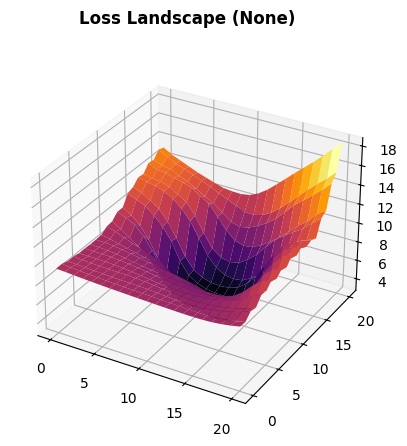

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, data_matrix, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
# ax.set_title(f'Surface Plot of Loss Landscape ({use_model})')
plt.suptitle(f'Loss Landscape ({use_model})', fontweight="bold")
fig.show()

[+] loss_landscape_files/loss_landscape_None_random_data_10_steps_21_distance_1_seed_123.png


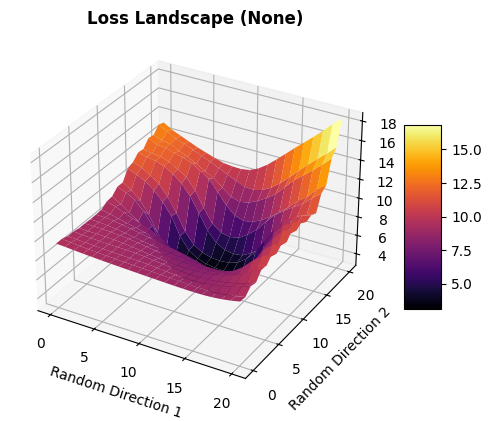

In [25]:
# for creating a responsive plot 
# %matplotlib widget

# importing required libraries 
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 

fig = plt.figure()

# Reshape the data_matrix into a 41x41 grid for plotting
Z = data_matrix.reshape((STEPS, STEPS))

# Generate X and Y coordinates (41x41 grid)
x = np.linspace(0, STEPS-1, STEPS)
y = np.linspace(0, STEPS-1, STEPS)
X, Y = np.meshgrid(x, y)

ax = fig.add_subplot(111, projection='3d')
# Plot the 3D surface with filled colors
surf = ax.plot_surface(X, Y, Z, cmap='inferno', edgecolor='none')

# Add a color bar for reference
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('Random Direction 1')
ax.set_ylabel('Random Direction 2')
# ax.set_zlabel('loss')

ax.set_title(f'Loss Landscape ({use_model})', fontweight="bold")

# plt.tight_layout()

save_as_png = f"loss_landscape_files/loss_landscape_{use_model}_random_data_{n_data}_steps_{STEPS}_distance_{DIST}_seed_{SEED}.png"
plt.savefig(save_as_png, dpi=300)
print(f"[+] {save_as_png}")
      
plt.show()
